In [198]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import Matrix
import time
from scipy import sparse
from copy import deepcopy
from sympy import Symbol, Interval
from sympy.stats import ContinuousRV, sample

In [18]:
def index_map(x, y, L):
    if x>L or y>L: return None
    return x*L + y

def exponential_dist_norm(x, a):
    return a*np.exp(-a*x)

def power_law_scale(x, a, scale):
    return scale*x**(-a)

def triangle_lattice_boundary_dictionary(L, include_nnn=False):
    ind_dict = {}
    adj_ind = {}
    bdry_dict = np.zeros(L*L,dtype=bool)
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nn indices
            adjs = [index_map(x,(y-1)%L, L), index_map(x,(y+1)%L, L)]
            
            if include_nnn: adjs += [index_map(x,(y+2)%L, L), index_map(x,(y-2)%L, L)]
            
            if x-1>=0:
                adjs.append(index_map((x-1)%L,y, L))
                adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))
                
                if include_nnn: adjs += [index_map((x-1)%L,(y+(-1)**(x%2))%L, L), index_map((x-1)%L,(y-2*(-1)**(x%2))%L, L)]
            if x+1<L:
                adjs.append(index_map((x+1),y, L))
                adjs.append(index_map((x+1),(y-(-1)**(x%2))%L, L))
                
                if include_nnn: adjs += [index_map((x+1)%L,(y+(-1)**(x%2))%L, L), index_map((x+1)%L,(y-2*(-1)**(x%2))%L, L)]
            
            if include_nnn:
                if x-2>=0:
                    adjs += [index_map((x-2)%L,y, L), index_map((x-2)%L,(y+1)%L, L), index_map((x-2)%L,(y-1)%L, L)]
                if x+2<L:
                    adjs += [index_map((x+2)%L,y, L), index_map((x+2)%L,(y+1)%L, L), index_map((x+2)%L,(y-1)%L, L)]
            
            if x==0: bdry_dict[ind_0] = True
            elif x==(L-1): bdry_dict[ind_0] = True      
                
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = list(set(adjs))
    return ind_dict, adj_ind, bdry_dict

def random_lin_dist_width(a, b, w, n_samples):
    x = Symbol('x')
    X = ContinuousRV(x, (a+b*x)/(a*w + b*w**2/2), Interval(0, w))
    return sample(X, size=(n_samples))

def fill_beta_vals_bdry(size, bdry_dict, lambda_bdry, lambda_blk):
    # Filling the log-field coupling with exponential distribution of different variance for bulk and boundary
    bdry_size = bdry_dict.sum()
    beta_vals = np.zeros(size)
    beta_vals[bdry_dict] = np.random.exponential(scale=lambda_bdry, size=bdry_size) #Filling boundary fields
    beta_vals[~bdry_dict] = np.random.exponential(scale=lambda_blk, size=(size-bdry_size))  #Filling bulk fields
    return beta_vals

def fill_zeta_ij_bdry(size, bdry_dict, adj_ind, a_mat, b_mat, w_mat):
    #Note, here a_mat, b_mat and w_mat are 2x2 symmetric matrices giving the distribution parameters for blk-blk, blk-bdry and
    #bdry-bdry couplings
    zeta_ij_vals = sparse.lil_matrix((size, size))
    for ind in range(size):
        
        tag = int(bdry_dict[ind])
        
        #Restrict to upper triangular part of matrix
        adj_ind_array = np.array(adj_ind[ind])
        upper_ind = adj_ind_array[adj_ind_array>ind]
        
        #Seperate adjacent indices into bulk and boundary
        bdry_ind = [i for i in upper_ind if bdry_dict[i]]
        blk_ind = [i for i in upper_ind if ~bdry_dict[i]]
        
        
        zeta_ij_vals[ind, bdry_ind] = sparse.lil_matrix(np.array  \
                                    (random_lin_dist_width(a_mat[tag, 1], b_mat[tag, 1], w_mat[tag, 1], len(bdry_ind))))

        zeta_ij_vals[ind, blk_ind] = sparse.lil_matrix(np.array  \
                                    (random_lin_dist_width(a_mat[tag, 0], b_mat[tag, 0], w_mat[tag, 0], len(blk_ind))))
        
    return zeta_ij_vals + zeta_ij_vals.T

In [263]:
class bdry_log_system:
    
    def __init__(self, size, adj_ind, bdry_dict, zeta_ij_vals, beta_vals, track_moments = False):
        
        self.size = size
        self.adj_ind = adj_ind
        self.zeta_ij_vals = zeta_ij_vals
        self.beta_vals = beta_vals
        self.bdry_dict = bdry_dict
        
        self.Gamma_array = []
        self.Gamma_0 = 0
        self.Gamma = 0
        self.num_dec = 0
        
        self.clust_dict = {i:i for i in range(size)}
        self.reverse_dict = {i:[i] for i in range(size)}
        
        self.track_moments = track_moments
        self.bdry_moment_list = [1.0]
        self.blk_moment_list = [1.0]
        
        self.beta_times = []
        self.zeta_times = []

        return None
    
    def decimate(self):
        beta_min, zeta_min = self.beta_vals[self.beta_vals>0].min(), self.zeta_ij_vals.data.min()
        Gamma = min(beta_min, zeta_min)
        
        start_time = time.time()
        if Gamma == zeta_min:
            self.zeta_decimation(Gamma)
            self.zeta_times.append(time.time()-start_time)
        elif Gamma == beta_min: 
            self.beta_decimation(Gamma)
            self.beta_times.append(time.time()-start_time)
        self.Gamma = Gamma
        self.Gamma_array.append(Gamma)
        
        if self.track_moments: 
            self.blk_moment_list.append(self.get_moment_bulk())
            self.bdry_moment_list.append(self.get_moment_bdry())
            
        self.num_dec+=1
        return None
    
    def zeta_decimation(self, Gamma):

        r_ind, c_ind, zeta_ij = sparse.find(self.zeta_ij_vals) 
        zeta_ind = np.where(zeta_ij == Gamma)[0][0]
        i, j = r_ind[zeta_ind], c_ind[zeta_ind]
        
        self.zeta_ij_vals.data += (self.Gamma_0 - Gamma) 
        self.beta_vals[self.beta_vals.nonzero()] += (self.Gamma_0 - Gamma) 
        
        self.clust_dict, self.reverse_dict = update_cluster(self.clust_dict, self.reverse_dict, i, j)

        self.beta_vals[i] +=  self.beta_vals[j]    
        self.beta_vals[j] = 0
        
        self.bdry_dict[i] = self.bdry_dict[i] or self.bdry_dict[j]
        self.bdry_dict[j] = self.bdry_dict[i]

        self.adj_ind = update_adjacency_zeta_ij(self.adj_ind, i, j)

        self.zeta_ij_vals[i,self.adj_ind[i]] += self.zeta_ij_vals[j, self.adj_ind[i]]
        self.zeta_ij_vals[i,self.adj_ind[i]] /= 2
        
        
        self.zeta_ij_vals[self.adj_ind[i], i] = self.zeta_ij_vals[i,self.adj_ind[i]]
        
        # Set the specified row to zero
        self.zeta_ij_vals.data[self.zeta_ij_vals.indptr[j]:self.zeta_ij_vals.indptr[j +1]] = 0

        # Set the specified column to zero
        bool_arr = self.zeta_ij_vals.indices == j
        self.zeta_ij_vals.data[bool_arr] = 0
        
        self.zeta_ij_vals.eliminate_zeros()
        
        return None
    
    def beta_decimation(self, Gamma):
        #GPTest2
        # Use in-place update instead of creating a new array with np.where
        i = np.flatnonzero(self.beta_vals == Gamma)[0]
        adj_i = self.adj_ind[i]

        # Update zeta_ij_vals and beta_vals in-place
        self.zeta_ij_vals.data += (self.Gamma_0 - Gamma)
        self.beta_vals[self.beta_vals.nonzero()] += (self.Gamma_0 - Gamma)

        # Retrieve subblock as dense matrix and perform computations in-place
        zeta_subblock = self.zeta_ij_vals[adj_i, :][:, adj_i].toarray()

        # Avoid using sparse.find which can be slower, directly access the data
        old_couplings = self.zeta_ij_vals[adj_i, i].data

        # Use np.outer instead of np.add.outer for performance, fill diagonal with 0
        new_couplings = np.add.outer(old_couplings, old_couplings)
        np.fill_diagonal(new_couplings, 0)

        # Update zeta_subblock in-place
        zeta_subblock[zeta_subblock == 0] = 1000
        np.minimum(zeta_subblock, new_couplings, out=zeta_subblock)

        # Convert updated zeta_subblock back to sparse and update zeta_ij_vals in-place
        self.zeta_ij_vals[np.ix_(adj_i, adj_i)] = sparse.csr_matrix(zeta_subblock)

        # Set the specified row to zero
        self.zeta_ij_vals.data[self.zeta_ij_vals.indptr[i]:self.zeta_ij_vals.indptr[i +1]] = 0

        # Set the specified column to zero
        self.zeta_ij_vals.data[self.zeta_ij_vals.indices == i] = 0

        # Remove zero entries from the sparse matrix
        self.zeta_ij_vals.eliminate_zeros()

        # Update adjacency
        self.adj_ind = update_adjacency_beta(self.adj_ind, i)
        return None
        
        
    def get_moment_bdry(self):
        rd = self.reverse_dict
        clust_size_list = np.array([len(clust) for clust in rd.values() if clust is not None and self.beta_vals[clust].any()>0 and self.bdry_dict[clust[0]]])
        return clust_size_list.mean()
    
    def get_moment_bulk(self):
        rd = self.reverse_dict
        clust_size_list = np.array([len(clust) for clust in rd.values() if clust is not None and self.beta_vals[clust].any()>0 and ~self.bdry_dict[clust[0]]])
        return clust_size_list.mean()


In [264]:
def update_adjacency_zeta_ij(adj_ind, i, j):
    #Updates adjaceny set of i with that of j
    #Also deletes index from the adjacency list of other indices
    adj_i = adj_ind[i]
    adj_j = adj_ind[j]
    
    adj_i_new = list(set(adj_i+adj_j))
    adj_i_new = list(set(adj_i_new)-set([i, j]))
    adj_ind[i] = adj_i_new
    adj_ind[j] = []
    
    for k in adj_i_new:
        adj_ind[k] = list(set(adj_ind[k]+[i])-set([j])-set([k]))
        
    return adj_ind

def update_adjacency_beta(adj_ind, i):
    #Updates adjacency set of every element in adj(i) with adj(i)
    #Also deletes index i from adj(k) for all k in adj(i)
    adj_i = adj_ind[i]
    
    for k in adj_ind[i]:
        adj_ind[k] = list(set(adj_ind[k]+adj_i)-set([i])-set([k]))
        
    adj_ind[i] = []
    return adj_ind
    
def update_cluster(cluster_dict, reverse_dict,site1, site2):
    #Takes in a dictionary containing the site->cluster mapping, cluster->set of sites mapping, and the two sites being decimated
    #Returns updated dictionaries, containing the new cluster data
    clust1 = cluster_dict[site1]   #cluster of site 1
    clust2 = cluster_dict[site2]   #cluster of site 2

    #Add spins in clust2 to clust1
    for dec_site in reverse_dict[clust2]:
        cluster_dict[dec_site] = clust1

    reverse_dict[clust1] += reverse_dict[clust2]
    reverse_dict[clust2] = None

    return cluster_dict, reverse_dict

In [265]:
def gen_check_list(size, steps, divs):
    i_vals = np.arange(divs)
    C = np.log(size/(size-steps))/(divs-1)
    return np.floor(size*np.exp(-i_vals * C)).astype(int)


L = 40
steps = int(0.995*L*L)
a_mat = np.array([[0.1, 0.1],[0.1, 0.1]])
b_mat = np.array([[0.105, 0.105],[0.105, 0.105]])

w_blk = 5
w_bdry = 5
w_mixed = 5

w_mat = np.array([[w_blk, w_mixed],[w_mixed, w_bdry]])


measure_list = L*L - gen_check_list(L*L, steps, 20)


zeta_dist_list_blk_blk = [np.array([]) for step in range(len(measure_list))]

beta_dist_list_blk = [np.array([]) for step in range(len(measure_list))]
beta_dist_list_bdry = [np.array([]) for step in range(len(measure_list))]

n_runs = 1

In [266]:
bdry_moments = np.zeros(steps+2)
blk_moments = np.zeros(steps+2)
st_time = time.time()
for run in range(n_runs):
    ind_dict, adj_ind, bdry_dict = triangle_lattice_boundary_dictionary(L)

    zeta_ij_vals = fill_zeta_ij_bdry(L*L, bdry_dict, adj_ind, a_mat, b_mat, w_mat)
    beta_vals = fill_beta_vals_bdry(L*L, bdry_dict, 1.,1.)

    test = bdry_log_system(L*L, adj_ind, bdry_dict, zeta_ij_vals, beta_vals, track_moments=True)

    check_list_acc = 0
    for i in range(steps+1):
            test.decimate()
            if i in measure_list:
                    beta_remain_blk = test.beta_vals[~bdry_dict]
                    beta_remain_blk = beta_remain_blk[beta_remain_blk!=0]

                    beta_remain_bdry = test.beta_vals[bdry_dict]
                    beta_remain_bdry = beta_remain_bdry[beta_remain_bdry!=0]

                    beta_dist_list_blk[check_list_acc] = np.concatenate((beta_dist_list_blk[check_list_acc],beta_remain_blk))
                    beta_dist_list_bdry[check_list_acc] = np.concatenate((beta_dist_list_bdry[check_list_acc],beta_remain_bdry))
                    
                    zeta_remain_blk_blk = test.zeta_ij_vals[~bdry_dict,:][:,~bdry_dict].data
                    zeta_dist_list_blk_blk[check_list_acc] = np.concatenate((zeta_dist_list_blk_blk[check_list_acc], zeta_remain_blk_blk))
                    
                    check_list_acc+=1
    blk_moments+=np.array(test.blk_moment_list)
    bdry_moments+=np.array(test.bdry_moment_list)
    
print(time.time()-st_time)

67.10079288482666


In [267]:
b_times = np.array(test.beta_times)
z_times = np.array(test.zeta_times)

print(b_times.mean(), z_times.mean())

0.010808760917288943 0.009454483370627126


(array([22.,  6.,  0.,  0.,  4.,  0.,  0.,  2.,  4.,  4.]),
 array([  6.1850577 , 105.39117206, 204.59728642, 303.80340078,
        403.00951515, 502.21562951, 601.42174387, 700.62785823,
        799.8339726 , 899.04008696, 998.24620132]),
 <BarContainer object of 10 artists>)

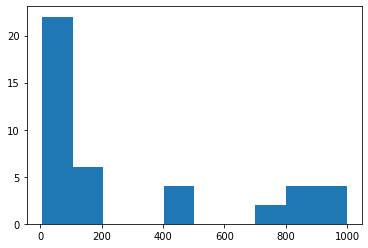

In [244]:
plt.hist(test.zeta_ij_vals.data)

/home/guaravtenkila/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


ValueError: array must not contain infs or NaNs

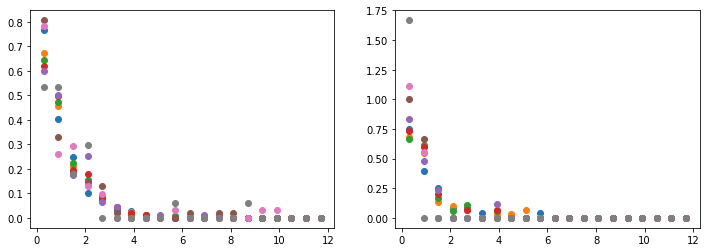

In [242]:
spins_left = L*L - measure_list
n_bins_h = 20
width_blk_list = []
width_bdry_list = []
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for i,step in enumerate(spins_left[:-1]): 
    n_blk,bins_blk = np.histogram(beta_dist_list_blk[i], density=True, bins = n_bins_h, range=(0, 12))
    width_blk = bins_blk[1]-bins_blk[0]
    x_blk = (bins_blk[1:]-width_blk/2)
    y_blk = n_blk 

    popt, pcov = curve_fit(exponential_dist_norm, x_blk[:10], y_blk[:10])
    #plt.plot(x, exponential_dist_norm(x, *popt))
    width_blk_list.append(1/popt[0])
    
    n_bdry,bins_bdry = np.histogram(beta_dist_list_bdry[i], density=True, bins = n_bins_h, range=(0, 12))
    width_bdry = bins_bdry[1]-bins_bdry[0]
    x_bdry = (bins_bdry[1:]-width_bdry/2)
    y_bdry = n_bdry
    if i%2==0:
        axes[0].scatter(x_blk, y_blk, label="N="+str(step), marker='o')
        axes[1].scatter(x_bdry, y_bdry, label="N="+str(step), marker='o')

    popt, pcov = curve_fit(exponential_dist_norm, x_bdry[:15], y_bdry[:15])
    #plt.plot(x, exponential_dist_norm(x, *popt))
    width_bdry_list.append(1/popt[0])

axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_xlim(0, 6)
axes[1].set_xlim(0, 6)
#plt.ylim(1e-1, 1)

axes[0].set_xlabel(r"Log field coupling $\beta$")
axes[0].set_ylabel(r"Distribution $R(\beta)$")
axes[0].set_title("Distribution of Field Couplings")
#plt.yscale('log')
axes[0].legend()

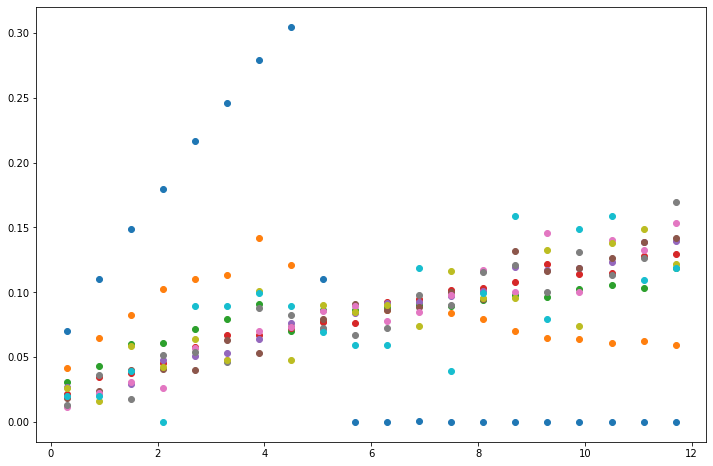

In [51]:
spins_left = L*L - measure_list
n_bins_h = 20
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.figure(figsize=(12, 8))

for i,step in enumerate(spins_left[:-1]): 
    n_blk,bins_blk = np.histogram(zeta_dist_list_blk_blk[i], density=True, bins = n_bins_h, range=(0,12))
    width_blk = bins_blk[1]-bins_blk[0]
    x_blk = (bins_blk[1:]-width_blk/2)
    y_blk = n_blk 

    x_bdry = (bins_bdry[1:]-width_bdry/2)
    y_bdry = n_bdry
    if i%2==0:
        plt.scatter(x_blk, y_blk, label="N="+str(step), marker='o')
        #axes[1].scatter(x_bdry, y_bdry, label="N="+str(step), marker='o')


#axes[0].set_yscale('log')
#axes[1].set_yscale('log')
#axes[0].set_xlim(0, 6)
#axes[1].set_xlim(0, 6)
#plt.ylim(1e-1, 1)

#axes[0].set_xlabel(r"Log field coupling $\beta$")
#axes[0].set_ylabel(r"Distribution $R(\beta)$")
#axes[0].set_title("Distribution of Field Couplings")
#plt.yscale('log')
#axes[0].legend()

[0.16063379 3.39752951]
[ 0.62992224 27.07362692]


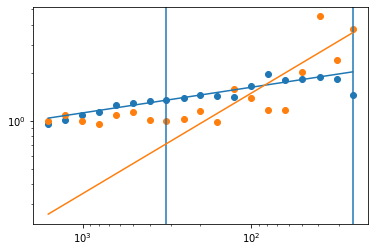

In [49]:
x = (L*L - measure_list)[:-1]
plt.scatter(x, width_blk_list)


start = -12
end = -1

plt.axvline(x=x[start])
plt.axvline(x = x[end])
popt, pcov = curve_fit(power_law_scale, x[start:end], width_blk_list[start:end])
plt.plot(x, power_law_scale(x, *popt))
print(popt)
plt.scatter(x, width_bdry_list)

popt, pcov = curve_fit(power_law_scale, x[start:end], width_bdry_list[start:end])
plt.plot(x, power_law_scale(x, *popt))
print(popt)
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')


<ipython-input-18-a75d9d4413bb>:9: RuntimeWarning: overflow encountered in multiply
  return scale*x**(-a)


0.45876937109850274 27.764236042189502
0.453492295987269 32.901595372043126


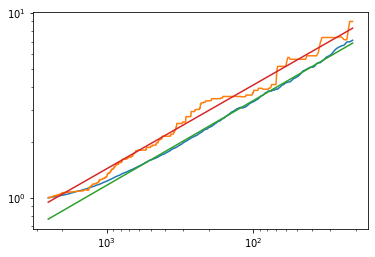

In [149]:
x = L*L - np.arange(steps)
y1 = blk_moments[1:-1]/2
y2 = bdry_moments[1:-1]/2

plt.plot(x, y1)
plt.plot(x, y2)

popt, pcov = curve_fit(power_law_scale, x[1500:], y1[1500:])
plt.plot(x, power_law_scale(x, *popt))
print(*popt)

popt, pcov = curve_fit(power_law_scale, x[1500:], y2[1500:])
plt.plot(x, power_law_scale(x, *popt))
print(*popt)

plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')

In [27]:
zeta_stuff = test.zeta_ij_vals
bdry_dict = test.bdry_dict

In [63]:
plt.hist(sparse.triu(test.zeta_ij_vals)[~test.bdry_dict,:][:,~test.bdry_dict].data)

TypeError: 'coo_matrix' object is not subscriptable

(array([30., 12., 16., 48., 50., 40., 36., 24., 12.,  4.]),
 array([ 2.19654228,  4.849007  ,  7.50147173, 10.15393645, 12.80640117,
        15.45886589, 18.11133061, 20.76379533, 23.41626005, 26.06872478,
        28.7211895 ]),
 <BarContainer object of 10 artists>)

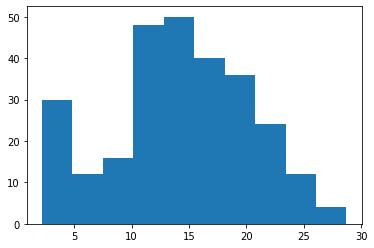

In [62]:
plt.hist(test.zeta_ij_vals[~test.bdry_dict,:][:,~test.bdry_dict].data)

In [65]:
import pandas as pd

In [66]:
x1 = np.arange(0, 10)
y1 = np.random.random(len(x1))

x2 = np.arange(0, 12)
y2 = np.random.random(len(x2))

In [68]:
#Try saving as a list of dictionaries (list indexed by timestamp)

#each dictionary contains input params and the x and y of the histograms

In [331]:
L = 10

a_mat = np.array([[0.1, 0.1],[0.1, 0.1]])
b_mat = np.array([[0.105, 0.105],[0.105, 0.105]])

w_blk = 3.5
w_bdry = 0.01
w_mixed = 5

w_mat = np.array([[w_blk, w_mixed],[w_mixed, w_bdry]])

ind_dict, adj_ind, bdry_dict = triangle_lattice_boundary_dictionary(L)

zeta_ij_vals = fill_zeta_ij_bdry(L*L, bdry_dict, adj_ind, a_mat, b_mat, w_mat)

(array([226.22133213,  56.55533303, 113.11066606, 113.11066606,
        226.22133213, 169.6659991 ,  56.55533303,  56.55533303,
          0.        , 113.11066606]),
 array([0.00084447, 0.00172856, 0.00261265, 0.00349674, 0.00438083,
        0.00526492, 0.00614901, 0.0070331 , 0.00791719, 0.00880128,
        0.00968537]),
 <BarContainer object of 10 artists>)

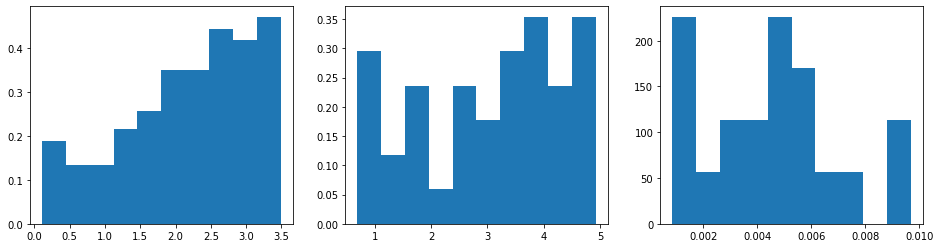

In [332]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

axes[0].hist(zeta_ij_vals[~bdry_dict,:][:,~bdry_dict].data, density=True)    #Bulk-Bulk
axes[1].hist(zeta_ij_vals[bdry_dict,:][:,~bdry_dict].data,density=True)       #Blk-Bdry
axes[2].hist(zeta_ij_vals[bdry_dict,:][:,bdry_dict].data, density=True)       #Bdry-Bdry

(array([232.72224374,  58.18056093, 174.5416828 , 349.08336561,
         58.18056093,   0.        ,  58.18056093,   0.        ,
         58.18056093, 174.5416828 ]),
 array([0.00050408, 0.00136347, 0.00222287, 0.00308226, 0.00394166,
        0.00480105, 0.00566044, 0.00651984, 0.00737923, 0.00823862,
        0.00909802]),
 <BarContainer object of 10 artists>)

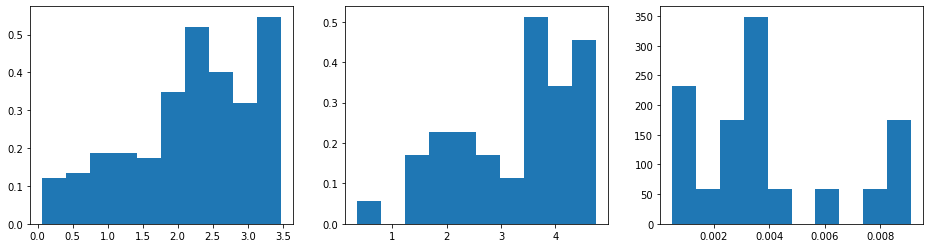

In [333]:
sampler = RandomLinDistWidthSampler(a_mat, b_mat, w_mat, L)

zeta_ij_vals = fill_zeta_ij_bdry_GPT(L*L, bdry_dict, sampler)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

axes[0].hist(zeta_ij_vals[~bdry_dict,:][:,~bdry_dict].data, density=True)    #Bulk-Bulk
axes[1].hist(zeta_ij_vals[bdry_dict,:][:,~bdry_dict].data,density=True)       #Blk-Bdry
axes[2].hist(zeta_ij_vals[bdry_dict,:][:,bdry_dict].data, density=True)       #Bdry-Bdry

In [334]:
t0 = time.time()
sampler = RandomLinDistWidthSampler(a_mat, b_mat, w_mat, L*10)
for i in range(10):
    fill_zeta_ij_bdry_GPT(L*L, bdry_dict, sampler)
print(time.time()-t0)



10.980445146560669


In [330]:
from scipy.sparse import dok_matrix

class RandomLinDistWidthSampler:
    def __init__(self, a, b, w, L):
        self.L = L
        X = Symbol('x')
        self.distributions = [ContinuousRV(X, (a[0,0]+b[0,0]*X)/(a[0,0]*w[0,0] + b[0,0]*w[0,0]**2/2), Interval(0, w[0,0])),\
                              ContinuousRV(X, (a[0,1]+b[0,1]*X)/(a[0,1]*w[0,1] + b[0,1]*w[0,1]**2/2), Interval(0, w[0,1])),\
                              ContinuousRV(X, (a[1,1]+b[1,1]*X)/(a[1,1]*w[1,1] + b[1,1]*w[1,1]**2/2), Interval(0, w[1,1]))]
        self.samples_cache = [None, None, None]

    def sample(self, coupling_type, n_samples):
        if self.samples_cache[coupling_type] is None or len(self.samples_cache[coupling_type]) < n_samples:
            self.samples_cache[coupling_type] = sample(self.distributions[coupling_type], size=(self.L*n_samples))  # get 10x needed
        result = self.samples_cache[coupling_type][:n_samples]
        self.samples_cache[coupling_type] = self.samples_cache[coupling_type][n_samples:]
        return result

sampler = RandomLinDistWidthSampler(a_mat, b_mat, w_mat, L)

def fill_zeta_ij_bdry_GPT(size, bdry_dict, sampler):
    zeta_ij_vals = dok_matrix((size, size))
    
    for ind in range(size):
        tag = int(bdry_dict[ind])
        
        adj_ind_array = np.array(adj_ind[ind])
        upper_ind = adj_ind_array[adj_ind_array>ind]
        
        bdry_ind = upper_ind[bdry_dict[upper_ind]]
        blk_ind = upper_ind[~bdry_dict[upper_ind]]
        
        zeta_ij_vals[ind, bdry_ind] = sampler.sample(tag+1, len(bdry_ind))
        zeta_ij_vals[ind, blk_ind] = sampler.sample(tag, len(blk_ind))
    
    zeta_ij_vals = zeta_ij_vals.tocsr()
    
    return zeta_ij_vals + zeta_ij_vals.T


In [350]:
ind_dict, adj_ind, bdry_dict = triangle_lattice_boundary_dictionary(L)
bdry_dict[:] = False
bdry_dict = np.append(bdry_dict, True)
ind_dict.update({L*L:(-1, 0)})
adj_ind[L*L] = []
for i in range(L):
    adj_ind[i] = adj_ind[i]+[L*L]
    adj_ind[L*L] = adj_ind[L*L]+[i]

101